In [7]:
import sys
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AtomPairs import Pairs
from tqdm.auto import tqdm

__all__ = [
    'ButinaCluster',
    'run',
]

class ButinaCluster:
    def __init__(self,fp_type="rdkit"):
        self.fp_type = fp_type

    def cluster_smiles(self,smi_list,sim_cutoff=0.8):
        mol_list = [Chem.MolFromSmiles(x) for x in tqdm(smi_list,desc="Calculating Fingerprints")]
        return self.cluster_mols(mol_list,sim_cutoff)

    def get_fps(self,mol_list):
        fp_dict = {
            "morgan2" : [AllChem.GetMorganFingerprintAsBitVect(x,2) for x in mol_list],
            "rdkit" : [Chem.RDKFingerprint(x) for x in mol_list],
            "maccs" : [MACCSkeys.GenMACCSKeys(x) for x in mol_list],
            "ap" : [Pairs.GetAtomPairFingerprint(x) for x in mol_list]
            }
        if fp_dict.get(self.fp_type) is None:
            raise KeyError(f"No fingerprint method defined for {self.fp_type}")

        return fp_dict[self.fp_type]
    
    def cluster_mols(self,mol_list,sim_cutoff=0.8):
        dist_cutoff = 1.0 - sim_cutoff
        #fp_list = [rdmd.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_list]
        fp_list = self.get_fps(mol_list)
        dists = []
        nfps = len(fp_list)
        for i in range(1,nfps):
            sims = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
            dists.extend([1-x for x in sims])
        mol_clusters = Butina.ClusterData(dists,nfps,dist_cutoff,isDistData=True)
        cluster_id_list = [0]*nfps
        for idx,cluster in enumerate(mol_clusters,1):
            for member in cluster:
                cluster_id_list[member] = idx
        return [x-1 for x in cluster_id_list]


def run(path, output, cutoff):
    df = pd.read_csv(path, sep=" ", names=["smiles", "Name"])
    butina_cluster = ButinaCluster("rdkit")
    df['cluster'] = butina_cluster.cluster_smiles(df.smiles.values, sim_cutoff=cutoff)
    df.sort_values("cluster", inplace=True)
    print(df.cluster.value_counts())
    df.to_csv(output, index=False)

In [4]:
import pandas as pd
import os
os.getcwd()

'C:\\Users\\sunoj'

In [5]:
df=pd.read_csv('genuine_phosphine_1902.csv')

In [6]:
df.head(3)

,smiles
0,CC1=CC=C(C=C1)P(C2=CC=C(C=C2)C)C3=CC=C(C=C3)C
1,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=CC=CC=C3C(=O)O
2,C1CCC(CC1)P(C2CCCCC2)C3CCCCC3


In [9]:
df.shape

(14720, 1)

In [10]:
#lets take only first 1000 mols
smiles_list=list(df['smiles'][:1000])

In [11]:
mols_list=[Chem.MolFromSmiles(i) for i in smiles_list]

In [8]:
butina=ButinaCluster()

In [15]:
for i in mols_list:
    if i is None:
        mols_list.remove(i)

In [17]:
mol_list=[]
for i in smiles_list:
    mol=Chem.MolFromSmiles(i)
    if mol != None:
        mol_list.append(i)

In [18]:
len(mol_list)

999

In [19]:
result=butina.cluster_smiles(mol_list,sim_cutoff=0.6)

In [20]:
len(set(result))

309

In [21]:
#so there are 309 groups 

In [22]:
df_cluster=pd.DataFrame(list(zip(mol_list, result)), columns=['smile', 'cluster'])

In [27]:
df_cluster=df_cluster.sort_values('cluster')

In [30]:
smile0=df_cluster[df_cluster['cluster']==0]['smile']

In [31]:
mol0=[Chem.MolFromSmiles(i) for i in smile0]

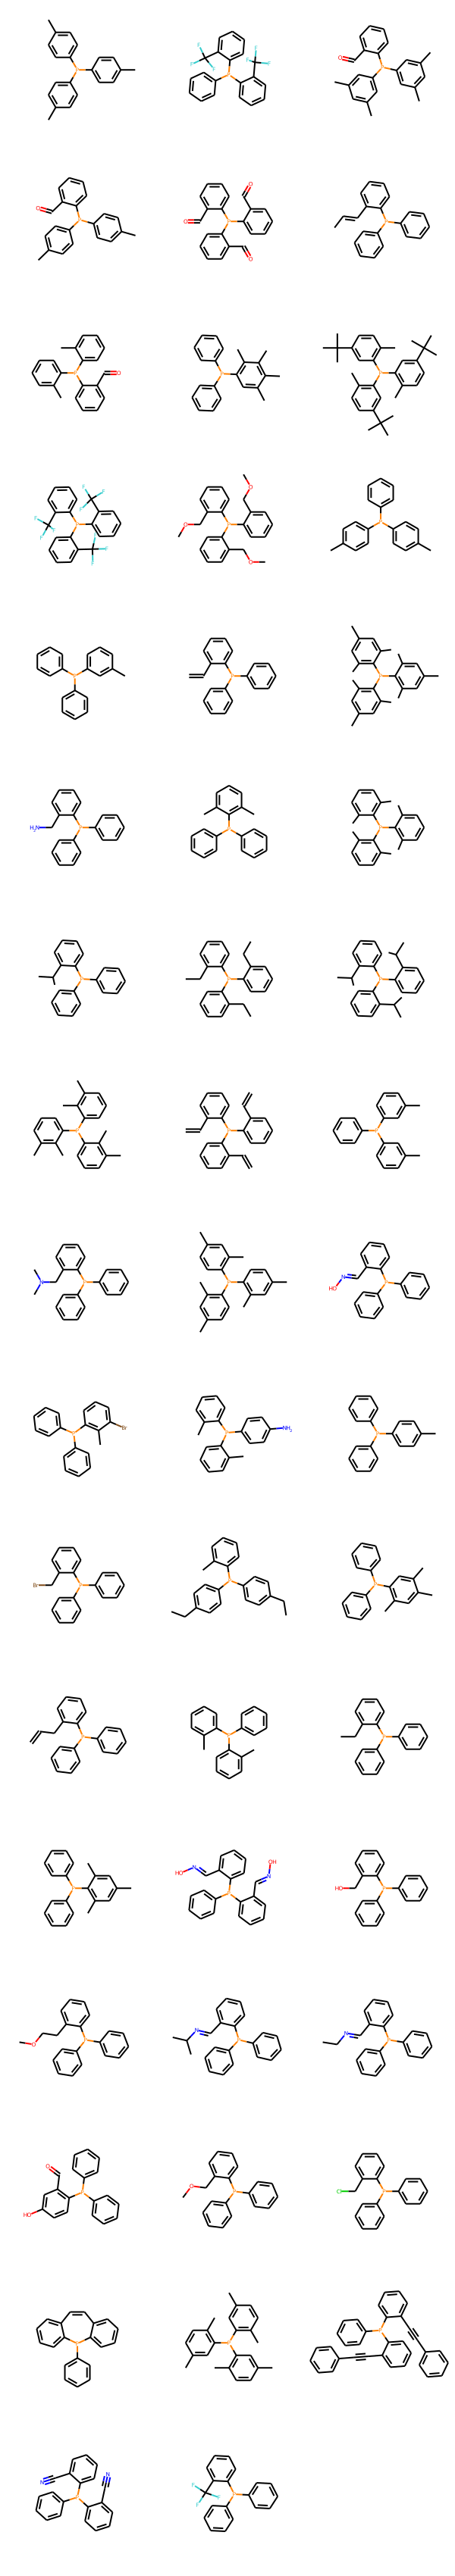

In [33]:
Chem.Draw.MolsToGridImage(mol0[:50])